# Orthohelium population

Writing a differential equation for the change in ortho-state:

$$\frac{d n^{o}}{dt} = \frac{3}{4} \alpha n_e n_{He II} 
- \Sigma n_i^o \int_{E_i} F_{\nu} B_{i,\inf} \ d\nu 
- \Sigma n_i^o A_i^{p}
- \Sigma n_i^o k n_e
$$


Here, the first term is recombination, second term is photo-ionization, third term is the E1 decay to ground state (ie. slow for the ground state) and fourth term is electron collision. 

We will assume the energy-levels of the triplet is Boltzman-distributed: 

$n_i^o= n_0^o e^{-(E_i-E_0^o)/kT}$

In [237]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.optimize import minimize
from dataclasses import dataclass
from dataclasses import dataclass, field
import astropy.units as u
import astropy.constants as const
from astropy.modeling.physical_models import BlackBody

# small helper function to make a numpy array field with a default value
make_np_field = lambda list, multiplier=1: field(default_factory=lambda: np.array(list)*multiplier)

# constants, in cgs units
erg_per_eV = u.eV.to(u.erg) # erg/eV
k_B = const.k_B.cgs.value  # erg/K# calculate density profile at t=1 day

rho = lambda v,t, rho0, p=5, v_0=0.2, t_0=1 : rho0 * (v/v_0)**-p * (t/t_0)**-3
# M = int dM/dV*dV/dr*dr/dv wrt dv
# r = 1 day * v
# M = int rho(v)*dV/dr*dr/dv wrt dv
# output in g/c
def dMdv(v, t):
    v = v*const.c
    t = t*u.day
    dr_dv = 1*u.day
    r = 1*u.day * v
    dV_dr = 4*np.pi*r**2
    dM_dV = rho(v, t, 1*u.g/u.cm**3, v_0=0.2*const.c, t_0=1*u.day)
    return (dM_dV.cgs * dV_dr.cgs * dr_dv.cgs * const.c).cgs.value
def get_density_profile(M_ej = 0.04 * u.M_sun, atomic_mass=4*u.u, mass_fraction=0.002):
    # we calculate the density profile at t=1 day, and normalize it to 0.04 solar mass
    rho_0 =  M_ej / (quad(dMdv, 0.1, 0.5, args=1)[0] * u.g/u.cm**3)
    number_density_0 = (rho_0 * mass_fraction / atomic_mass).cgs.value
    print(rho_0, mass_fraction, atomic_mass)
    return lambda v, t: rho(v, t, number_density_0)

# Environment class, contains all the parameters of the environment
# and calculates the derived parameters constant for all ortho populations.
# can be initialized with the default values as Environment(), or with custom values
# as Environment(t_d=1.43, T=4000, UV_shielding=0.9). 
@dataclass
class Environment:
    # input values
    t_d: float = 1.43 # days. Yes Days. The second cgs unit of time, apparently.
    T: float = 4000  # K
    UV_shielding:float = 0.9 # fraction shielded
    M_ejecta: float = 0.04 # solar masses
    mass_fraction: float = 0.002 # mass fraction of helium
    
    # Level properties. Can be lengthened to include more levels
    # Must all be ordered the same way
    multiplicities: np.ndarray = make_np_field([1,3]) # 1 for singlet, 3 for triplet
    energies: np.ndarray = make_np_field([19.82, 20.96], erg_per_eV)  # eV
    A_rates: np.ndarray = make_np_field([1.272e-04, 1.764e+02])  #s^-1
    names: list = field(default_factory=lambda: ["1s2s_ortho", "1s2p_ortho"]) # names of levels in cross-section files
    
    # dervied values, calculated in __post_init__ based on the above values
    bolzmann_factors : np.ndarray = None # From T and energies
    ionization_rates : np.ndarray = None # From T and energies
    collision_k : np.ndarray = None
    alpha: float = None #cm^3/s, calculate based on temp
    n_e: float = None # count/cm^3	
    n_HeII: float = None # count/cm^3

    # Calculate derived values based on the input values
    def __post_init__(self):
        self.bolzmann_factors = self.calculate_bolzmann_factors(self.energies, self.T)
        self.ionization_rates = self.calculate_ionization_integrals(self.T, self.names, self.UV_shielding)
        self.collision_k = self.calculate_collision_k(self.T, self.multiplicities)
        self.alpha = self.calculate_alpha(self.T)
        self.n_e, self.n_HeII = self.calculate_number_densities(self.t_d, 0.04 * , 0.002, 0.2, self.t_d)

    # Calculate the bolzmann factors for a given temperature
    @staticmethod
    def calculate_bolzmann_factors(E, T):
        return np.exp(-(E-E[0])/(k_B*T))

    # integrate product between shielded BB and crossection
    @staticmethod
    def calculate_ionization_integrals(T, names, UV_shielding):
        # make cthe blackbody spectrum, scaled by the UV shielding and per-wavelength
        bb = BlackBody(T * u.K, scale=UV_shielding*u.Unit("erg/(nm s sr cm2)")) 
        ionization_rates = []
        for name in names:
            E, sigma = np.fliplr(np.loadtxt(name + "_ionization.csv", unpack=True))
            E = (E * u.Ry).cgs
            wl = E.to(u.nm, equivalencies=u.spectral())
            sigma = (sigma * u.Mbarn).cgs
            ionization_flux_article = np.pi**2*4*u.sr * sigma * (bb(wl)/E * UV_shielding)
            ionization_rates.append(np.trapz(x=wl, y=ionization_flux_article).to(1/u.s).value)
        return np.array(ionization_rates)

    # Calculate collisional de-excitation rate
    @staticmethod
    def calculate_collision_k(T, multiplicities):
        return 8.63*10**-6/(np.sqrt(T) * multiplicities)

    # Calculate recombination efficiency
    @staticmethod
    def calculate_alpha(T):   
        """ 
        A_rates: 
        From 3P to singlet ground, A = 1.764e+02 (ie. time-scale of 0.005 s)
        From 3S to singlet ground, A = 1.272e-04 (ie. time-scale of hours)
        Thus, the dominant path-way down should be from the triplet first exited state. 
        """
        T_list = [3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0]
        alpha_list = [1.99e-12, 1.71e-12, 1.47e-12, 1.27e-12, 1.09e-12, 9.32e-13, 
        7.98e-13, 6.84e-13, 5.85e-13, 5.00e-13, 4.28e-13]

        return interp1d(T_list, alpha_list)( np.log10(T) )    

    # Calculate number densities of n_e and n_HeII respectively
    # assuming level population of ortho-HeI is negligible
    @staticmethod
    def calculate_number_densities(t_d, M_ejecta, Y_He, v_line, t):
        n_He_profile = get_density_profile(M_ejecta, atomic_mass=4*u.u, mass_fraction=0.002)
        n_HeII = n_He_profile(v_line, t_d)
        return 1.5e8 * t_d**-3, 



def recombination_rate(level_pop, env):
    return 3/4 * env.alpha * env.n_e * env.n_HeII

def ionization_rate(level_pop, env):
    return np.sum(level_pop * env.ionization_integrals)

def natural_decay_rate(level_pop, env):
    return sum(level_pop * env.A_rates)

def collision_rate(level_pop, env):
    return sum(level_pop * env.collision_k * env.n_e)

def dn_ortho_dt(n0_ortho, env): 
    level_pop = n0_ortho * env.multiplicities
    return recombination_rate(level_pop, env) - ionization_rate(level_pop, env) - natural_decay_rate(level_pop, env) - collision_rate(level_pop, env)

def steady_state_n_ortho(env):
    return minimize(dn_ortho_dt, env.n_HeII, args=(env))

def grid_search(property, values):
    results = []
    for value in values:
        env = Environment(**{property:value})
        results.append(steady_state_n_ortho(env))

grid_search("UV_shielding", np.geomspace(0.01,100))

TypeError: Environment.calculate_number_densities() missing 5 required positional arguments: 't_d', 'M_ejecta', 'Y_He', 'v_line', and 't'

# Ionization flux diagnostics

TypeError: Environment.calculate_number_densities() missing 3 required positional arguments: 't_d', 'M_ejecta', and 'Y_He'

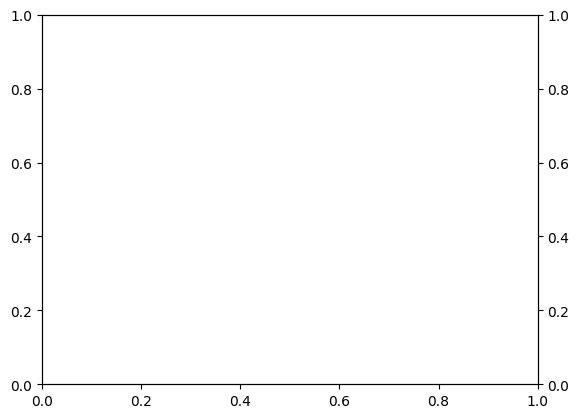

In [182]:
import astropy.units as u
import astropy.constants as const
from astropy.modeling.physical_models import BlackBody
import scipy.integrate 
# convenience function for integrating with units
cumtrapz = lambda x,y: scipy.integrate.cumulative_trapezoid(x=x.value, y=y.value, initial=0)*y.unit*x.unit  


for day, T in zip([1.43, 2.42, 3.41, 4.40], [4000, 3150, 2750, 2600]):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    env = Environment(t_d=day, T=T)
    R_phot = (1.43 * u.day * (0.4 * const.c)).cgs
    R_line = (1.43 * u.day * (0.4 * const.c)).cgs
    bb = BlackBody(T * u.K, scale=1*u.Unit("erg/(nm s sr cm2)")) 
    states=["1s2s", "1s2p"]

    wls = []
    ion_rates = []
    for state in states:
        E, sigma = np.fliplr(np.loadtxt(state + "_ionization.csv", unpack=True))
        E = (E * u.Ry).cgs
        sigma = (sigma * u.Mbarn).cgs
        freq = E.to(u.Hz, equivalencies=u.spectral())
        wl = freq.to(u.nm, equivalencies=u.spectral())

        # http://www.astro.yale.edu/vdbosch/astro320_summary24.pdf page 3
        surface_luminosity = 4 * np.pi**2 * u.sr**2 * R_phot ** 2 * bb(wl)  # total emitted energy flux per wavelength times cone size
        energy_flux = surface_luminosity / (4 * np.pi * u.sr * R_line ** 2) # energy flux per area per wavelength at the line forming region
        # could also just write the above as energy_flux = bb(freq) * (pi * u.sr) * (R_phot / R_line) ** 2

        # http://www.astro.yale.edu/vdbosch/astro320_summary24.pdf page 1
        number_density = 4 * np.pi * energy_flux / (const.c.cgs * const.h.cgs * freq) # photons per second per wavelength per volume (per frequency/times time?)
        ion_rate = const.c.cgs * sigma * number_density # photon ionization rate per wavelength per second
        ion_rate = ion_rate.to(1/(u.s*u.nm))
        cum_ion_rate = cumtrapz(x=wl, y=ion_rate)
        wls.append(wl)
        ion_rates.append(ion_rate)
        ax1.plot(wl, ion_rate, label=rf"{state}, $\tau={(1/cum_ion_rate[-1]).si:.3}$")
        ax1.set_xlabel(f"photon wl [{wl.unit}]")
        ax1.set_ylabel(f"ionization rate [{ion_rate.unit}]")
    
        #
        ax2.plot(wl, cum_ion_rate/cum_ion_rate[-1], alpha=0.5, linestyle="--")

        ########################
        ### TESTED: this is the same as the above, but given in the article, with geometric factor np.pi**2*4 ~ 40
        ### For now just use the above, since it's more general

        # ionization_flux_article = np.pi**2*4*u.sr * sigma * bb(wl)/E # photon ionization rate per frequency per second
        # ionization_rate = np.trapz(x=wl, y=ionization_flux_article)
        # print(ionization_rate)
        ########################

    wl_grid = np.linspace(min(map(min, wls)), max(map(max, wls)), 100)
    total_ion_rates = np.zeros(len(wl_grid)) * ion_rates[0].unit
    for wl, ion_rate, bolz, mult in zip(wls, ion_rates, env.bolzmann_factors, env.multiplicities):
        total_ion_rates += np.interp(wl_grid, wl, ion_rate) * bolz * mult / sum(env.bolzmann_factors * env.multiplicities)

    cum_total_ion_rate = cumtrapz(x=wl_grid, y=total_ion_rates)
    ax1.plot(wl_grid, total_ion_rates, label=rf"total, $\tau={(1/cum_total_ion_rate[-1]).si:.3}$")
    ax2.plot(wl_grid, cum_total_ion_rate/cum_total_ion_rate[-1], alpha=0.5, linestyle="--")

    # http://www.astro.yale.edu/vdbosch/astro320_summary24.pdf
    plt.title(f"Photoionization lifetime at {T=}")
    plt.xlim(200, 350)
    ax1.set_ylim(1e-5, 100)
    ax1.set_yscale("log")
    ax1.legend()
    plt.xlabel("photon wl [nm]")
    #plt.ylabel("Photoionization Cross section (Mb)")
    ax1.set_ylabel("Ionization rate per ion per frequency (# / (s * nm))")
    ax2.set_ylabel("Cumulative ionization photons fraction")
    #plt.xlim(3, 6)
    plt.show()


# Check of density calculation

1.1924922778585649e-47 cm3 solMass / g 0.002 4.0 u
1.1924922778585649e-47 cm3 solMass / g 0.01 87.62 u


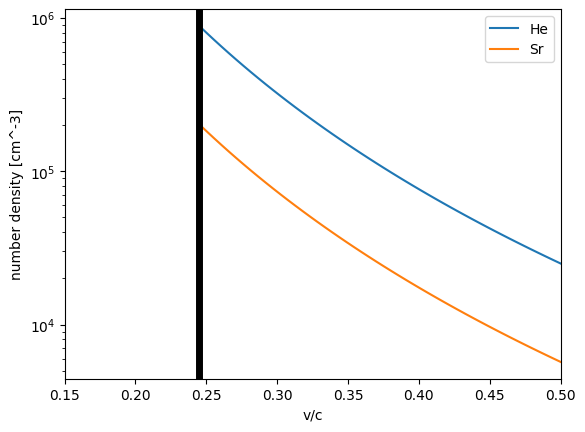

In [234]:
# calculate density profile at t=1 day

rho = lambda v,t, rho0, p=5, v_0=0.2, t_0=1 : rho0 * (v/v_0)**-p * (t/t_0)**-3
# M = int dM/dV*dV/dr*dr/dv wrt dv
# r = 1 day * v
# M = int rho(v)*dV/dr*dr/dv wrt dv
# output in g/c
def dMdv(v, t):
    v = v*const.c
    t = t*u.day
    dr_dv = 1*u.day
    r = 1*u.day * v
    dV_dr = 4*np.pi*r**2
    dM_dV = rho(v, t, 1*u.g/u.cm**3, v_0=0.2*const.c, t_0=1*u.day)
    return (dM_dV.cgs * dV_dr.cgs * dr_dv.cgs * const.c).cgs.value
def get_density_profile(M_ej = 0.04 * u.M_sun, atomic_mass=4*u.u, mass_fraction=0.002):
    # we calculate the density profile at t=1 day, and normalize it to 0.04 solar mass
    rho_0 =  M_ej / (scipy.integrate.quad(dMdv, 0.1, 0.5, args=1)[0] * u.g/u.cm**3)
    number_density_0 = (rho_0 * mass_fraction / atomic_mass).cgs.value
    print(rho_0, mass_fraction, atomic_mass)
    return lambda v, t: rho(v, t, number_density_0)
Y_He = 0.002 # fraction by mass (sec 4.1)
m_He = 4*u.u # mass of He
Y_Sr = 0.01 # fraction by mass (sec 4.1)
m_Sr = 87.62 *u.u # mass of He
x_range = np.linspace(0.245, 0.5)
density_profile = get_density_profile(atomic_mass=m_He, mass_fraction=Y_He)
plt.semilogy(x_range, density_profile(x_range, 1.43), label="He")
density_profile = get_density_profile(atomic_mass=m_Sr, mass_fraction=Y_Sr)
plt.semilogy(x_range, density_profile(x_range, 1.43), label="Sr")
#plt.ylim(1e-6, 1e6)
plt.xlim(0.15, 0.5)
plt.axvline(x=0.245, c="k", linewidth=5)
plt.xlabel("v/c")
plt.ylabel("number density [cm^-3]")
plt.legend()
# make ticks on every power of 10 on the y axis
plt.gca().yaxis.set_major_locator(plt.LogLocator(numticks=10))

In [180]:
import sympy as sp

rho_0, v_0, v, t, t_0, r, c = sp.symbols("rho_0, v_0, v, t, t_0, r, c")
v = r / (c * t)
rho = rho_0 * (v/v_0)**-5 * (t/t_0)**-3

M_tot = sp.Integral(rho * 4 * sp.pi * r**2, (r, 0.1*t/c, 0.5*t/c)).doit()
rho_0 = sp.solve(sp.Eq(M_tot, 0.04), rho_0)[0]
rho_0 = rho_0.evalf(subs={v_0:0.1, t_0:1, t:1.43, c:1})
(rho_0 * u.M_sun/(u.s * scipy.constants.c * u.m/u.s)**3 * Y_He / (4*u.u)).cgs
#M_tot#rho.evalf(subs={})

<Quantity 1.47357959e+23 1 / cm3>

In [197]:
(0.04 * u.M_sun * Y_He / (0.3 * const.c * 1.43 * u.day)**3 / (4*u.u)).cgs

<Quantity 17454668.12625643 1 / cm3>

In [195]:
17454668 / 30086805

0.5801436210990166

In [552]:
wl_range = np.linspace(200, 350, 100) * u.nm
E, sigma = np.fliplr(np.loadtxt(state + "_ionization.csv", unpack=True))
E = E * u.Ry
sigma = (sigma * u.Mbarn).cgs
freq = E.to(u.Hz, equivalencies=u.spectral())
wl = freq.to(u.nm, equivalencies=u.spectral())
np.interp(wl_range, wl, sigma)

<Quantity [3.18068501e-18, 3.24970974e-18, 3.31988509e-18, 3.39024652e-18,
           3.46060794e-18, 3.53196657e-18, 3.60361525e-18, 3.67526392e-18,
           3.75786110e-18, 3.84970649e-18, 3.94155187e-18, 4.03086857e-18,
           4.10611754e-18, 4.18136651e-18, 4.25661548e-18, 4.33252439e-18,
           4.40888485e-18, 4.48524530e-18, 4.56160576e-18, 4.65602973e-18,
           4.75355945e-18, 4.85108918e-18, 4.94861890e-18, 5.02971339e-18,
           5.10931439e-18, 5.18891540e-18, 5.26851640e-18, 5.38119716e-18,
           5.50386355e-18, 5.62652993e-18, 5.74919632e-18, 5.86523594e-18,
           5.97090991e-18, 6.07658389e-18, 6.18225786e-18, 6.28793184e-18,
           6.39553811e-18, 6.50374570e-18, 6.61195329e-18, 6.72016088e-18,
           6.82836847e-18, 6.91891633e-18, 7.00669099e-18, 7.09446565e-18,
           7.18224031e-18, 7.27001496e-18, 7.38903189e-18, 7.52341704e-18,
           7.65780219e-18, 7.79218734e-18, 7.92657248e-18, 8.06167981e-18,
           8.20078218e-18

1733051805.9144266 erg / (s cm2)
[0.00000000e+00 5.97287591e-36 1.48277899e-35 2.79549286e-35
 4.74148272e-35 7.62615005e-35 1.19021280e-34 1.82402360e-34
 2.76346166e-34 4.15585171e-34 6.21951001e-34 9.27794099e-34
 1.38105001e-33 2.05274493e-33 3.04811441e-33 4.52307403e-33
 6.70861717e-33 9.94695351e-33 1.47450362e-32 2.18538407e-32
 3.23857809e-32 4.79885981e-32 7.11028779e-32 1.05343393e-31
 1.56063793e-31 2.31192753e-31 3.42472022e-31 5.07289481e-31
 7.51393031e-31 1.11290840e-30 1.64828709e-30 2.44111132e-30
 3.61512762e-30 5.35353906e-30 7.92756015e-30 1.17386798e-29
 1.73812095e-29 2.57348500e-29 3.81016747e-29 5.64088347e-29
 8.35085013e-29 1.23621669e-28 1.82994785e-28 2.70871225e-28
 4.00928495e-28 5.93404327e-28 8.78241727e-28 1.29974106e-27
 1.92344095e-27 2.84629531e-27 4.21172464e-27 6.23187486e-27
 9.22053345e-27 1.36418028e-26 2.01820698e-26 2.98564163e-26
 4.41659433e-26 6.53303548e-26 9.66317869e-26 1.42923059e-25
 2.11378935e-25 3.12606514e-25 4.62286341e-25 6.8359

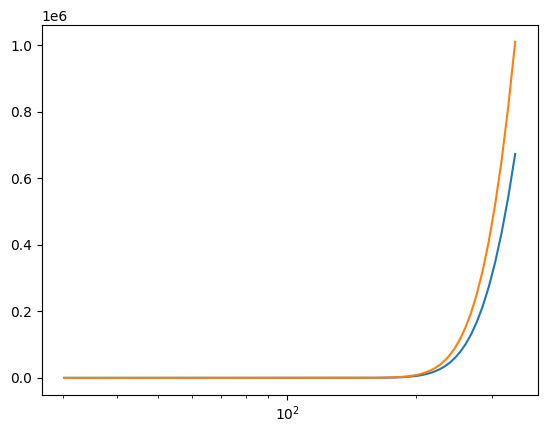

In [595]:
# declare a blackbody as a function of wavelength
T = 4000 * u.K
bb = BlackBody(T, scale=1*u.Unit("erg/(nm s sr cm2)")) 
cumtrapz = lambda x,y: scipy.integrate.cumulative_trapezoid(x=x.value, y=y.value, initial=0)*y.unit*x.unit
plt.plot(wl, bb(wl))
bb = BlackBody(T, scale=1.5*u.Unit("erg/(nm s sr cm2)")) 
plt.plot(wl, bb(wl))
print(np.trapz(x=wl, y=bb(wl))*4*np.pi**2*u.sr)
print(cumtrapz(x=wl, y=bb(wl))*4*np.pi**2*u.sr)
print(wl.unit, bb(wl).unit)
print(bb.bolometric_flux)
bb = BlackBody(T) 
print(cumtrapz(x=wl.to(u.Hz, equivalencies=u.spectral()), y=bb(wl))[-1])
plt.xscale("log")

In [431]:
sum(env.bolzmann_factors * env.multiplicities)

1.018464114768631

In [428]:
env.bolzmann_factors, env.multiplicities

(array([1.       , 0.0061547]), array([1, 3]))

In [406]:
cum_trap

array([8.39351230e-31, 6.32284516e-27, 1.38913698e-23, 1.04273125e-20,
       2.97572197e-18, 4.30460175e-16, 3.39628971e-14, 1.62471659e-12,
       5.29296203e-11, 1.18031463e-09, 1.98713361e-08, 2.57477785e-07,
       2.66768839e-06, 2.26563084e-05, 1.63823860e-04, 1.02214448e-03,
       5.54527309e-03, 2.66870313e-02, 1.14492111e-01, 4.52250396e-01,
       1.63099604e+00, 5.44025820e+00, 1.67394352e+01, 4.85712542e+01,
       1.33110652e+02, 3.44516363e+02, 8.45423771e+02, 1.98115499e+03,
       4.43011912e+03, 9.58072795e+03, 1.99036651e+04, 3.98401981e+04,
       7.75609682e+04, 1.45935715e+05, 2.67383380e+05, 4.78179077e+05,
       8.34657221e+05, 1.42473531e+06, 2.37905042e+06, 3.88190596e+06,
       6.20431847e+06, 9.75216168e+06, 1.51338091e+07, 2.31660563e+07,
       3.48372266e+07, 5.14815392e+07, 7.50219829e+07, 1.08213798e+08,
       1.54317148e+08, 2.17454112e+08, 3.03013547e+08, 4.17168620e+08,
       5.68719869e+08, 7.69143847e+08, 1.03014052e+09, 1.36569879e+09,
      

In [381]:
np.interp(wl_grid.cgs, wl.cgs, ion_rate.cgs)

<Quantity [6.55292504e+08, 5.59309790e-38, 5.59309790e-38, 5.59309790e-38,
           5.59309790e-38, 5.59309790e-38, 5.59309790e-38, 5.59309790e-38,
           5.59309790e-38, 5.59309790e-38, 5.59309790e-38, 5.59309790e-38,
           5.59309790e-38, 5.59309790e-38, 5.59309790e-38, 5.59309790e-38,
           5.59309790e-38, 5.59309790e-38, 5.59309790e-38, 5.59309790e-38,
           5.59309790e-38, 5.59309790e-38, 5.59309790e-38, 5.59309790e-38,
           5.59309790e-38, 5.59309790e-38, 5.59309790e-38, 5.59309790e-38,
           5.59309790e-38, 5.59309790e-38, 5.59309790e-38, 5.59309790e-38,
           5.59309790e-38, 5.59309790e-38, 5.59309790e-38, 5.59309790e-38,
           5.59309790e-38, 5.59309790e-38, 5.59309790e-38, 5.59309790e-38,
           5.59309790e-38, 5.59309790e-38, 5.59309790e-38, 5.59309790e-38,
           5.59309790e-38, 5.59309790e-38, 5.59309790e-38, 5.59309790e-38,
           5.59309790e-38, 5.59309790e-38, 5.59309790e-38, 5.59309790e-38,
           5.59309790e-38

In [332]:
wl_grid = np.linspace(min(map(min, wls)), max(map(max, wls)), 100) 
wl_grid

<Quantity [ 30.17013042,  33.30606519,  36.44199995,  39.57793471,
            42.71386948,  45.84980424,  48.98573901,  52.12167377,
            55.25760853,  58.3935433 ,  61.52947806,  64.66541283,
            67.80134759,  70.93728235,  74.07321712,  77.20915188,
            80.34508665,  83.48102141,  86.61695617,  89.75289094,
            92.8888257 ,  96.02476047,  99.16069523, 102.29663   ,
           105.43256476, 108.56849952, 111.70443429, 114.84036905,
           117.97630382, 121.11223858, 124.24817334, 127.38410811,
           130.52004287, 133.65597764, 136.7919124 , 139.92784716,
           143.06378193, 146.19971669, 149.33565146, 152.47158622,
           155.60752099, 158.74345575, 161.87939051, 165.01532528,
           168.15126004, 171.28719481, 174.42312957, 177.55906433,
           180.6949991 , 183.83093386, 186.96686863, 190.10280339,
           193.23873815, 196.37467292, 199.51060768, 202.64654245,
           205.78247721, 208.91841198, 212.05434674, 215.19028